# 2x2 Coupler

An example creating a 2x2 coupler using gdsfactory's built-in methods. This will mostly be me following the tutorial in the [gdsfactory docs](https://gdsfactory.github.io/gdsfactory/notebooks/meep/001_meep_sparameters.html#parallel-simulation-multicore-mpi).

In [1]:
import numpy as np

import meep as mp
import gdsfactory as gf
import gdsfactory.simulation.gmeep as gm
import gdsfactory.simulation as sim
from gdsfactory.simulation.modes import find_modes_waveguide

Using MPI version 4.0, 1 processes


2023-03-09 13:43:16.181 | WARNING  | gdsfactory.config:showwarning:60 - The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
2023-03-09 13:43:16.182 | WARNING  | gdsfactory.config:showwarning:60 - The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
2023-03-09 13:43:16.182 | WARNING  | gdsfactory.config:showwarning:60 - The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-p

## Setup

First we define the materials and geometry in the simulation. This will be a standard silicon-on-insulator design with a 220nm waveguide embedded in SiO2 at a wavelength of 1550nm, and we will ignore the substrate for now.

The device will be a 2x2 port setup and we will use gdsfactory's built-in coupler component with length and gap spacing as prescribed in the [Meep docs](https://meep.readthedocs.io/en/latest/Python_Tutorials/GDSII_Import/#s-parameters-of-a-directional-coupler).

In [2]:
sim_res = 20
n_si = 3.4777
n_sio2 = 1.444
z_wvg = 0.22
lambda0 = 1.55

c = gf.components.coupler(length=8, gap=0.13)

2023-03-09 13:43:16.984 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.



We can exploit the device's mirror symmetries in x and y to define port symmetries - the optical reponse must be the same for those ports due to reciprocity. This lets us run only one simulation to get all S-parameters instead of four (one for each port).

In [3]:
port_symmetries_coupler = {
    "o1@0,o1@0": ["o2@0,o2@0", "o3@0,o3@0", "o4@0,o4@0"],
    "o2@0,o1@0": ["o1@0,o2@0", "o3@0,o4@0", "o4@0,o3@0"],
    "o3@0,o1@0": ["o1@0,o3@0", "o2@0,o4@0", "o4@0,o2@0"],
    "o4@0,o1@0": ["o1@0,o4@0", "o2@0,o3@0", "o3@0,o2@0"],
}

In the interest of time, we will be doing 2D effective index simulations instead. We calculate the effective index of the fundamental TE mode of the waveguide and use the index of that mode to perform our simulations.

Note that the effective index method is only an approximation and works best in a setting with relatively low effective refractive index contrast and few interfaces, where out-of-plane scattering is not a (big) concern. While the results should give a decent indication of device performance, they can not replace full-wave simulations.

In [4]:
neff = find_modes_waveguide(
    parity=mp.ODD_Y + mp.EVEN_Z,  # TE
    wg_width=0.5,
    ncore=n_si,
    nclad=n_sio2,
    wg_thickness=z_wvg,
    resolution=2 * sim_res,
    sy=6,
    sz=4,
    nmodes=1,
)[1].neff
neff = float(neff)
neff

2023-03-09 13:43:21.513 | WARNING  | gdsfactory.config:showwarning:60 - Casting complex values to real discards the imaginary part
/users/tfp/yaugenst/dev/code/gf_fork/gdsfactory/typings.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(val, dtype=cls.inner_type)


2.4445354137083

## S-parameter calculation

Now we use gdsfactory's Meep integration to obtain the S-parameters of the coupler.

But first, let's visualize simulation layout.

epsilon: 2.08514-12.0944, mean 2.1311, harm. mean 2.09351, 100% > 1, 0.459201% "fill"
Using MPI version 4.0, 8 processes

Elapsed run time = 26.6877 s

2023-03-09 13:43:30.154 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 13:43:30.160 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 13:43:30.160 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 13:43:30.160 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 13:43:30.161 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 13:43:30.161 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 13:43:30.168 | WARNING  | gdsfactory.pdk:get_active_pdk:561 - No active PDK. Activating generic PDK.

2023-03-09 13:43:30.168 | WARNING  | gdsfactory.pdk:get_a

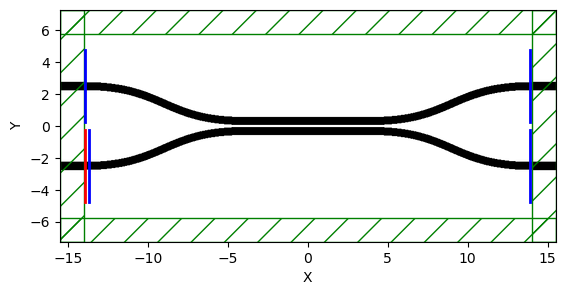

In [5]:
_ = gm.write_sparameters_meep(
    component=c,
    port_source_names=["o1"],
    resolution=sim_res,
    is_3d=False,
    material_name_to_meep={"si": neff, "sio2": n_sio2},
    port_symmetries=port_symmetries_coupler,
    run=False,
)

Now for the actual simulation, using `write_sparameters_meep_mpi` running on multiple cores using MPI.

In [6]:
fp = gm.write_sparameters_meep_mpi(
    component=c,
    port_source_names=["o1"],
    resolution=sim_res,
    is_3d=False,
    material_name_to_meep={"si": neff, "sio2": n_sio2},
    cores=8,
    port_symmetries=port_symmetries_coupler,
    overwrite=True,
)
sp = np.load(fp)

## Results

First, let's plot all obtained S-parameters.

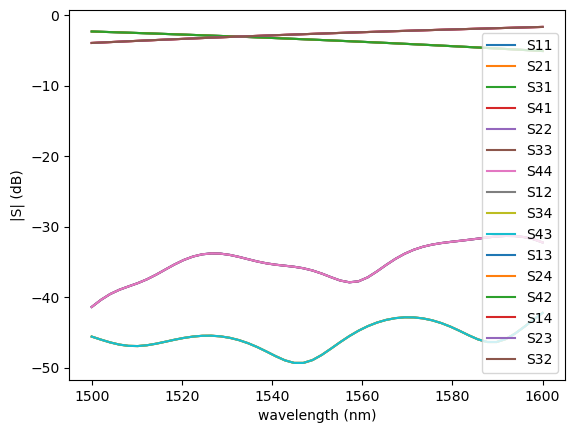

In [7]:
sim.plot.plot_sparameters(sp)

### Excess loss

Now we plot the excess loss. This is just $10 \log(|S_{13}|^2 + |S_{14}|^2)$ and thankfully, gdsfactory has a convenient built-in for that.

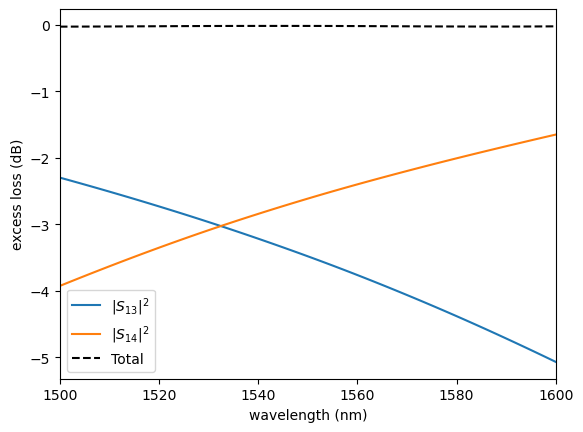

In [8]:
sim.plot.plot_loss2x2(sp)

## Imbalance

The imbalance is the difference between the power in the two output ports, and we define it here as: $10 \log(1 - (|S_{13}|^2 - |S_{14}|^2))$

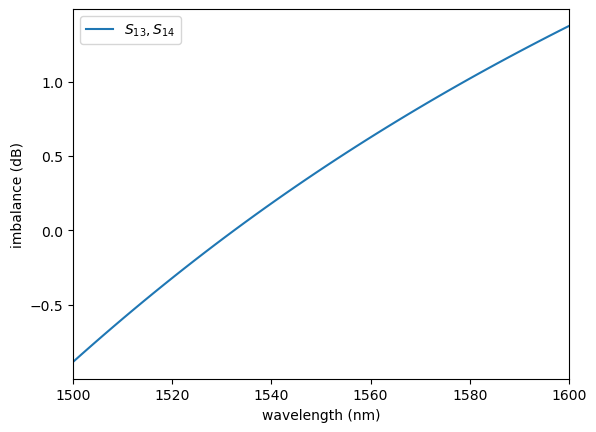

In [9]:
sim.plot.plot_imbalance2x2(sp)

## Reflection

The reflection is captured by the S-parameters $S_{11}$ and $S_{21}$, i.e. the power that is registered by the monitors at the input ports.

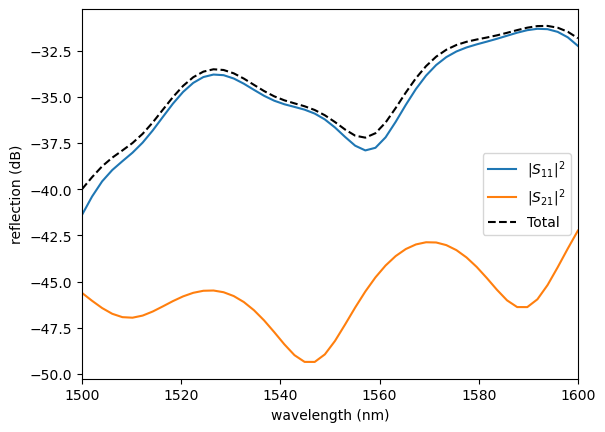

In [10]:
sim.plot.plot_reflection2x2(sp)

## Discussion

We note that the coupler has an imbalance greater than zero at the target wavelength of 1550nm, and the perfect 50/50 splitting is shifted slightly to a lower wavelength. This is not too surprising, as we introduced multiple sources of errors here. Most importantly perhaps, our materials do not correspond exactly to the ones used in the Meep tutorial! But there are also errors stemming from the effective index method as well as discretization errors that stem from the low resolution that we chose. In that sense, it is almost surprising that we got as close as we did!